# Dynamics of scalar-modulated system

Dynamics equation:

$\dot{x}(x, t) = u(t)w(x) + v_0(x); \;\; x(0) = 0$

## Candidate recipe for stabilizing through scalar modulation:

Choose $u(t)$ fluctuating approx on timescale of expected timing errors to correct.

Pick any $w(x^*(t))$ same sign as $du/dt(t)$ for all $t$.

Pick $v_0(x^*(t))$ s.t. $\dot{x}^*(t) = u(t)w(x^*(t)) + v_0(x^*(t))$ for all $t$.

In [1]:
%matplotlib inline
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage import gaussian_filter1d as smooth
import sys

from aux import Generic, get_idx
from disp import set_font_size

# Model trajectory generation

In [2]:
DT = .01
DX = .01

DN = 10  # factor to multiply by to get downsampled arrays

T_MAX = 32
X_MAX = 32

T_STOP = 30

TAU_ETA = 1
SGM_0 = .4
SGM = SGM_0/np.sqrt(DT)

T_MOD = 2*np.pi

N_TR = 300

W_SCALE = .75

............................................................................................................................................................................................................................................................................................................

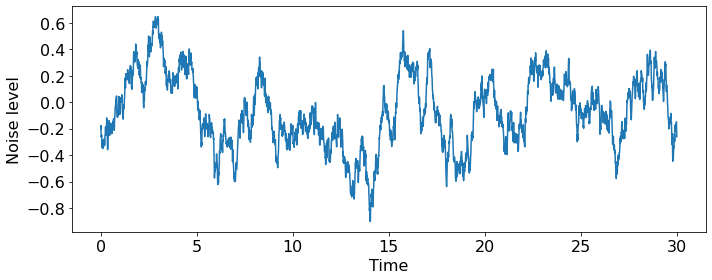

In [3]:
# fixed structures
t_smln = np.arange(0, T_STOP, DT)

## noise process
t_eta = np.arange(-5*TAU_ETA, T_STOP+5*TAU_ETA, DT)
mt_eta = (0 <= t_eta) & (t_eta < T_STOP)

## speed landscape
t = np.arange(0, T_MAX, DT)
x = np.arange(0, X_MAX, DX)

u_arr = 1 + np.cos(2*np.pi*t/T_MOD)
w_arr = -W_SCALE*np.sin(2*np.pi*x/T_MOD)
v0_arr = 1 - u_arr*w_arr


## funcs for getting nearest value

def u(t_):
    return u_arr[get_idx(t_, 0, DT, len(t))]

def w(x_):
    return w_arr[get_idx(x_, 0, DX, len(x))]

def v0(x_):
    return v0_arr[get_idx(x_, 0, DX, len(x))]

# trial loop
np.random.seed(None)
x_trs = []  # trials
x_trs_ctl = []  # control trials with no speed correction

for ctr in range(N_TR):
    sys.stdout.write('.')
    # sample O-U noise
    eta = np.nan * np.zeros(len(t_eta))
    eta[0] = 0

    for ct, t_ in enumerate(t_eta[1:], 1):
        eta[ct] = eta[ct-1] + (DT/TAU_ETA) * (-eta[ct-1] + SGM*np.random.randn())

    eta = eta[mt_eta]

    if ctr == 0:  # plot example noise to make sure looks okay
        fig, ax = plt.subplots(1, 1, figsize=(10, 4), tight_layout=True)
        ax.plot(t_smln, eta)
        ax.set_xlabel('Time')
        ax.set_ylabel('Noise level')
        set_font_size(ax, 16)

    # main simulation loop
    x_tr = np.nan * np.zeros(len(t_smln))
    x_tr_ctl = np.nan * np.zeros(len(t_smln))

    x_tr[0] = 0
    x_tr_ctl[0] = 0

    for ct, _t in enumerate(t_smln[1:], 1):
        
        # speed-corrected trial
        _x = x_tr[ct-1]

        _v = u(_t)[0]*w(_x)[0] + v0(_x)[0] + eta[ct]
        _v = np.clip(_v, 0, 2)  # no negative velocities, and max is twice true velocity
        x_tr[ct] = _x + _v*DT

        # matched non-speed-corrected control trial
        _x = x_tr_ctl[ct-1]

        _v = 1 + eta[ct]
        _v = np.clip(_v, 0, 2)  # no negative velocities, and max is twice true velocity
        x_tr_ctl[ct] = _x + _v*DT

    x_trs.append(x_tr.copy())
    x_trs_ctl.append(x_tr_ctl.copy())
    
x_trs = np.array(x_trs)
x_trs_ctl = np.array(x_trs_ctl)

In [4]:
# save
t_dn = np.arange(0, T_MAX, DT*DN)
x_dn = np.arange(0, X_MAX, DX*DN)

u_arr_dn = 1 + np.cos(t_dn)
w_arr_dn = -W_SCALE*np.sin(x_dn)
v0_arr_dn = 1 - u_arr_dn*w_arr_dn

# save trajectories
np.save(
    f'trj_set_t_stop_{T_STOP}_sgm_0_{SGM_0}_tau_eta_{TAU_ETA}_t_mod_{T_MOD:.3f}_n_tr_{N_TR}.npy',
    np.array([{
        'DT': DT,
        'DX': DX,
        'N_TR': N_TR,
        'T_STOP': T_STOP,
        'T_MAX': T_MAX,
        'X_MAX': X_MAX,
        'SGM_0': SGM_0,
        'TAU_ETA': TAU_ETA,
        'T_MOD': T_MOD,
        'W_SCALE': W_SCALE,
        't_smln': t_smln,
        't': t,
        'x_trs': x_trs,
        'x_trs_ctl': x_trs_ctl,
        'w_arr_dn': w_arr_dn,
        'u_arr_dn': u_arr_dn,
        'v0_arr_dn': v0_arr_dn,
    }])
    )